In [1]:
import sys
import os
import requests

import torch
import numpy as np

import matplotlib.pyplot as plt
from PIL import Image

if 'google.colab' in sys.modules:
    print('Running in Colab.')
    !pip3 install timm==0.4.5  # 0.3.2 does not work in Colab
    !git clone https://github.com/facebookresearch/mae.git
    sys.path.append('./mae')
else:
    sys.path.append('./mae')


In [2]:
import models_mae

In [3]:
dataset_mean = np.array([0.3834, 0.3956, 0.3531])
dataset_std = np.array([0.1969, 0.1771, 0.1742])

def show_image(image, title=''):
    # image is [H, W, 3]
    assert image.shape[2] == 3
    plt.imshow(torch.clip((image * dataset_std + dataset_mean) * 255, 0, 255).int())
    plt.title(title, fontsize=16)
    plt.axis('off')
    return

def prepare_model(chkpt_dir, arch='mae_vit_large_patch16', use_mae=False, 
                  use_positional_embedding=False, use_pos_pred=False, use_contrastive=False):
    # build model
    model = getattr(models_mae, arch)(use_mae=use_mae, 
                                      use_positional_embedding=use_positional_embedding,
                                      use_pos_pred=use_pos_pred,
                                      use_contrastive=use_contrastive
                                     )
    # load model
    checkpoint = torch.load(chkpt_dir, map_location='cpu')
    msg = model.load_state_dict(checkpoint['model'], strict=False)
    print(msg)
    return model

def run_one_image(img, model):
    x = torch.tensor(img)

    # make it a batch-like
    x = x.unsqueeze(dim=0)
    x = torch.einsum('nhwc->nchw', x)

    # run MAE
    loss, y, mask = model(x.float(), mask_ratio=0.75)
    y = model.unpatchify(y)
    y = torch.einsum('nchw->nhwc', y).detach().cpu()

    # visualize the mask
    mask = mask.detach()
    mask = mask.unsqueeze(-1).repeat(1, 1, model.patch_embed.patch_size[0]**2 *3)  # (N, H*W, p*p*3)
    mask = model.unpatchify(mask)  # 1 is removing, 0 is keeping
    mask = torch.einsum('nchw->nhwc', mask).detach().cpu()
    
    x = torch.einsum('nchw->nhwc', x)

    # masked image
    im_masked = x * (1 - mask)

    # MAE reconstruction pasted with visible patches
    im_paste = x * (1 - mask) + y * mask

    # make the plt figure larger
    plt.rcParams['figure.figsize'] = [24, 24]

    plt.subplot(1, 4, 1)
    show_image(x[0], "original")

    plt.subplot(1, 4, 2)
    show_image(im_masked[0], "masked")

    plt.subplot(1, 4, 3)
    show_image(y[0], "reconstruction")

    plt.subplot(1, 4, 4)
    show_image(im_paste[0], "reconstruction + visible")

    plt.show()

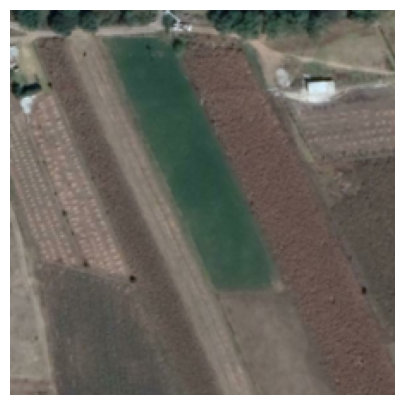

In [7]:
# load an image
img_url = "../datasets/Million-AID1/train/train/agriculture_land/arable_land/dry_field/P0103696.jpg" # P0103696, P0089220 
img = Image.open(img_url).convert('RGB')
img = img.resize((224, 224))
img = np.array(img) / 255.

assert img.shape == (224, 224, 3)

# normalize by ImageNet mean and std
img = img - dataset_mean
img = img / dataset_std

plt.rcParams['figure.figsize'] = [5, 5]
show_image(torch.tensor(img))

## MAE with Positional Embedding 

In [19]:
chkpt_path = '/media/tonio/p2/ssl-medical-satellite/mae/mae_baseline_satellite/checkpoint-49.pth'
# TODO: implement fix to not change models_mae.py, line 83 to 1 for model to load 
model_mae = prepare_model(chkpt_path, 'mae_vit_base_patch16', use_mae=True, use_positional_embedding=True)
print('Model loaded.')

<All keys matched successfully>
Model loaded.


MAE with pixel reconstruction:


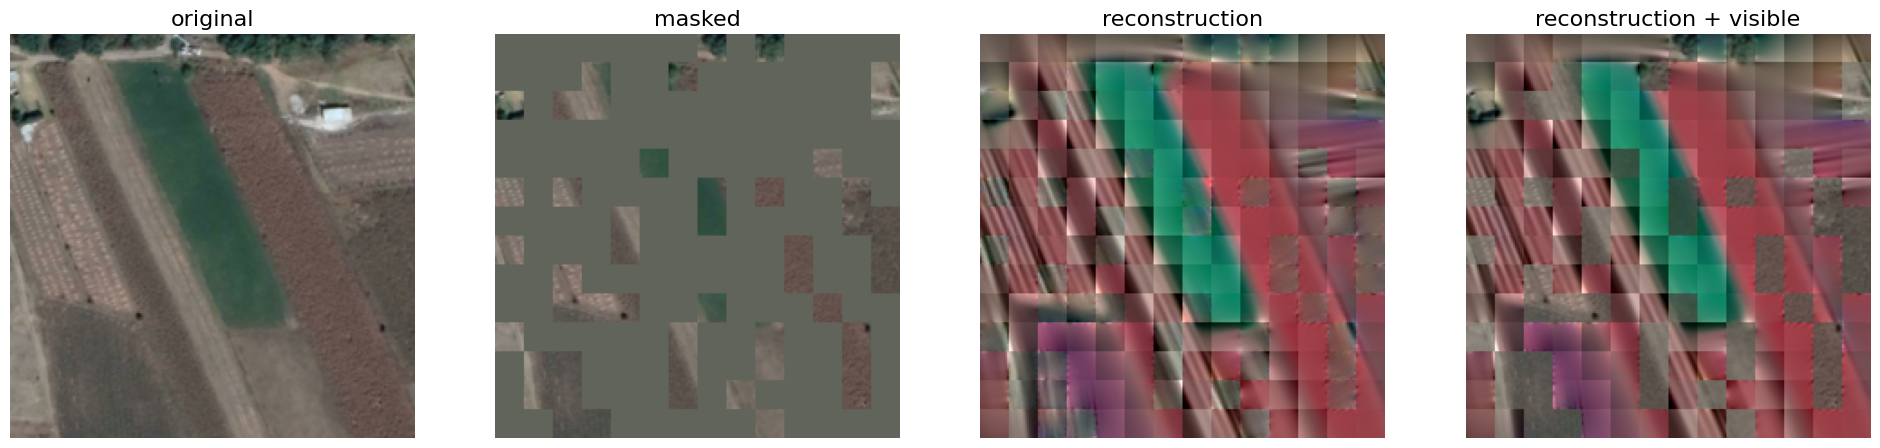

In [20]:
torch.manual_seed(2)
print('MAE with pixel reconstruction:')
run_one_image(img, model_mae)

## MAE with no Positional Embedding 

In [23]:
chkpt_path = '/media/tonio/p2/ssl-medical-satellite/mae/mae_baseline_satellite_without_pos_emb/checkpoint-49.pth'
# TODO: change models_mae.py, line 83 to 1 for model to load 
model_mae = prepare_model(chkpt_path, 'mae_vit_base_patch16', use_mae=True, use_positional_embedding=False)
print('Model loaded.')

<All keys matched successfully>
Model loaded.


MAE with pixel reconstruction:


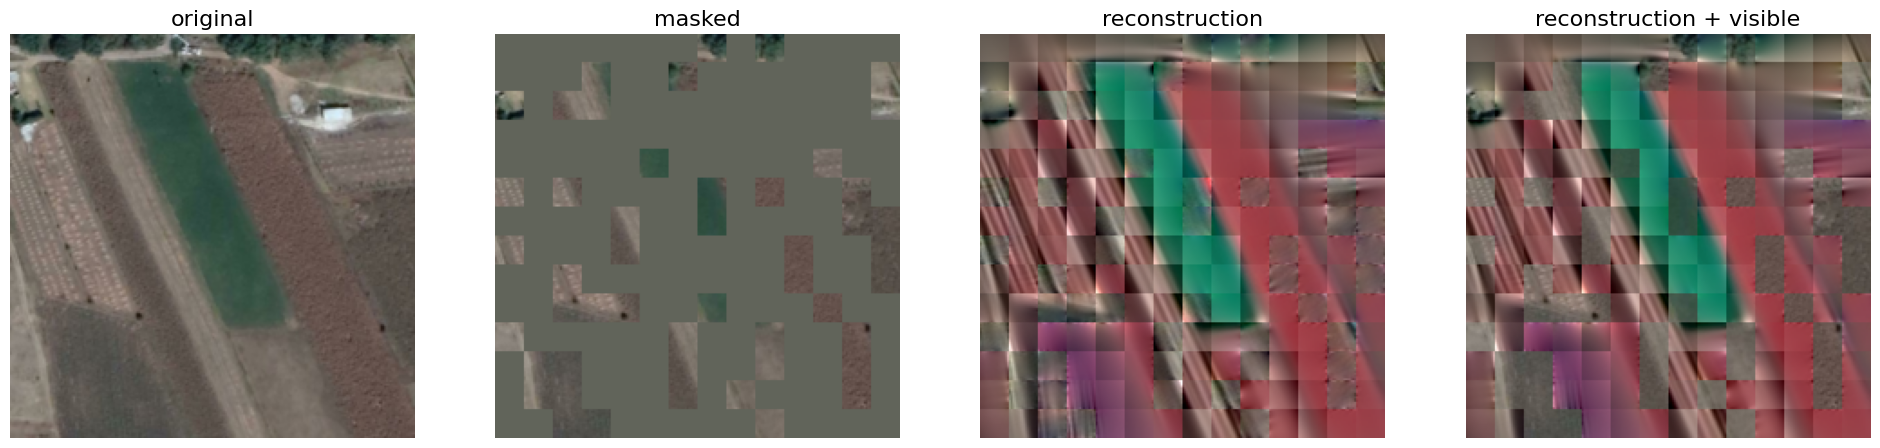

In [24]:
torch.manual_seed(2)
print('MAE with pixel reconstruction:')
run_one_image(img, model_mae)